# Building a Classification Model for New Kickstarter Submissions

Determine whether new kickstarter submissions are likely to meet their goals, using project details (days between launch and target date, Goal target, number of backers, dollars pledged per backer and whether past project met their goal; state_successful =1) based on Kickstarter data from April 2009 - January 2018. 

### First, import all necessary modules and the historical dataset to build the EDA and Classification model:

In [65]:
#import all dictionaries

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime, timedelta, date
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [66]:
#load dataset

kick = pd.read_csv('/Users/dkrupnik/Documents/ga-datascience/ga-projects/Data/ks-projects-201801.csv')

### Begin examining the dataset to search for and manage any null values

In [67]:
#Examining dataset for total rows and data types

kick.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


In [68]:
#Generate descriptive summary for all continuous metrics

kick.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [69]:
# Count all null values in all columns

kick.isna().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [70]:
# Fill all null values in the 'usd pledged' column with '0'

kick[['usd pledged']] = kick[['usd pledged']].fillna(0)

### Examine the dataset for which variables would be most effective in assisting the accuracy of the classification model

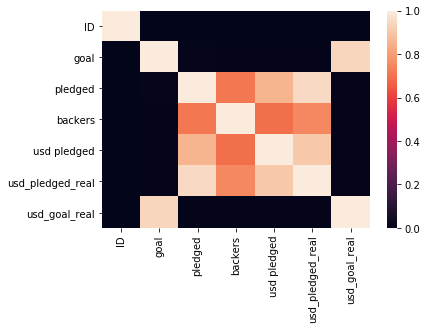

In [71]:
#Generate a heatmap for an initial view on variable correlation

corr = kick.corr()
sns.heatmap(corr)

### Understand the distribution for the Goal and Backers columns

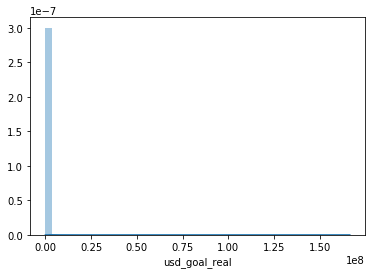

In [72]:
sns.distplot(kick['usd_goal_real'], hist=True)

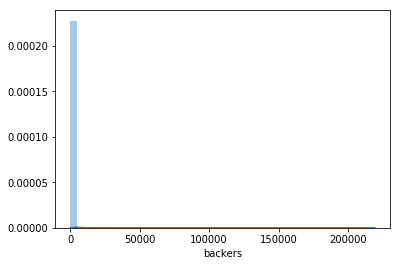

In [73]:
sns.distplot(kick['backers'], hist=True)

### Normalize distributions for the Goal and Backers columns

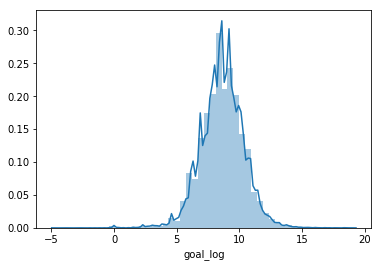

In [74]:
kick['goal_log'] = np.log(kick[(kick['usd_goal_real'] >0)].usd_goal_real)
sns.distplot(kick['goal_log'], hist=True)

In [75]:
kick['backers'].isna().sum()

0

ValueError: cannot convert float NaN to integer

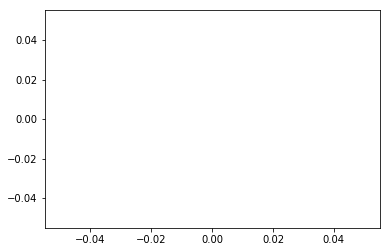

In [76]:
kick['backers_log'] = np.log(kick[(kick['backers'] >0)].backers, drop)
sns.distplot(kick['backers_log'], hist=True)

### Develop new features of the dataset to assist in more accurately predicting success

In [77]:
#convert dates to datetime

kick['deadline'] = pd.to_datetime(kick['deadline'])
kick['launched'] = pd.to_datetime(kick['launched'])

#reformatting dates
kick['day_diff'] = (kick.deadline - kick.launched)
kick['day_diff'] = (kick.day_diff / np.timedelta64(1, 'D')).astype(int)

#average dollars per day
kick['dpd'] = kick['usd_pledged_real'] / kick['day_diff']

#average dollars to raise per day
kick['dpd_to_goal'] = kick['goal_log'] / kick['day_diff']

#dollars per backer
kick['pledged_per_backer'] = kick['usd_pledged_real'] / kick['backers']

#pledge to goal metrics
kick['pledge-to-goal_tot'] = kick['usd_pledged_real'] - kick['usd_goal_real']
kick['pledge-to-goal_perc'] = kick['usd_pledged_real'] / kick['usd_goal_real']

#backers to integers
kick['backers'] = pd.to_numeric(kick['backers'])

In [78]:
# Write a function that will categorize project Goals in to quartiles

def get_goal_quartile(i):
    g0 = kick['usd_goal_real'].quantile(q=.0)
    g25 = kick['usd_goal_real'].quantile(q=.25)
    g50 = kick['usd_goal_real'].quantile(q=.50)
    g75 = kick['usd_goal_real'].quantile(q=.75)
    g100 = kick['usd_goal_real'].quantile(q=1)
    
    gq=[]
    for gval in i:
        if gval >= g0 and gval < g25:
            gq.append('0-25th percentile')
        elif gval >= g25 and gval < g50:
            gq.append('25-50th percentile')
        elif gval >= g50 and gval < g75:
            gq.append('50-75th percentile')
        elif gval >= g75 and gval < g100:
            gq.append('75-99th percentile')
        else:
            gq.append('PROBLEM')
    return gq
    
    
kick['goal_quartile'] = get_goal_quartile(kick['usd_goal_real'])

In [79]:
# Write a function that will categorize project Pledge in to quartiles

def get_pledge_quartile(i):
    p0 = kick['usd_pledged_real'].quantile(q=.0)
    p25 = kick['usd_pledged_real'].quantile(q=.25)
    p50 = kick['usd_pledged_real'].quantile(q=.50)
    p75 = kick['usd_pledged_real'].quantile(q=.75)
    p100 = kick['usd_pledged_real'].quantile(q=1)
    
    pq=[]
    for val in i:
        if pval >= p0 and pval < p25:
            pq.append('0-25th percentile')
        elif pval >= p25 and pval < p50:
            pq.append('25-50th percentile')
        elif pval >= p50 and pval < p75:
            pq.append('50-75th percentile')
        elif pval >= p75 and pval < p100:
            pq.append('75-99th percentile')
        else:
            pq.append('PROBLEM')
    return pq
    
    
kick['pledged_quartile'] = get_goal_quartile(kick['usd_pledged_real'])

In [80]:
# Write a function that will categorize project Backers in to quartiles

def get_backers_quartile(i):
    b0 = kick['backers'].quantile(q=.0)
    b25 = kick['backers'].quantile(q=.25)
    b50 = kick['backers'].quantile(q=.50)
    b75 = kick['backers'].quantile(q=.75)
    b100 = kick['backers'].quantile(q=1)
    
    bq=[]
    for val in i:
        if bval >= b0 and pval < b25:
           bq.append('0-25th percentile')
        elif bval >= b25 and pval < b50:
            bq.append('25-50th percentile')
        elif bval >= b50 and pval < b75:
            bq.append('50-75th percentile')
        elif bval >= b75 and pval < b100:
            bq.append('75-99th percentile')
        else:
            bq.append('PROBLEM')
    return bq
    
    
kick['backers_quartile'] = get_goal_quartile(kick['backers'])

### Create dummy variables for the newly created features

In [81]:
#get dummies for new columns

kick = pd.get_dummies(kick, columns=['goal_quartile', 'main_category', 'backers_quartile', 'pledged_quartile', 'state'])

### Find variable correlations versus rows where State equals 'Successful'

In [82]:
#Understand the correlation between the depending variable ('state_successful') and all other variables

kick.corr().state_successful.sort_values(ascending = False)

state_successful                       1.000000
backers_log                            0.653771
pledged_quartile_75-99th percentile    0.340461
pledged_quartile_50-75th percentile    0.312254
backers_quartile_0-25th percentile     0.275141
pledged_quartile_25-50th percentile    0.266281
goal_quartile_0-25th percentile        0.143401
backers                                0.129109
dpd                                    0.115237
pledged                                0.111534
usd_pledged_real                       0.110704
usd pledged                            0.098114
main_category_Music                    0.093623
backers_quartile_25-50th percentile    0.091500
pledged_per_backer                     0.088703
main_category_Theater                  0.088260
main_category_Comics                   0.066792
goal_quartile_25-50th percentile       0.064823
main_category_Dance                    0.055926
backers_quartile_50-75th percentile    0.048789
main_category_Art                      0

### Split the dataset into train and test sets then create variables and fit the variables to the model

In [83]:
# Create variables for the model

knn = KNeighborsClassifier(n_neighbors = 3)
X = kick[['goal_log', 'day_diff', 'backers']]
y = kick['state_successful']

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Fit and score the train and test sets to the model

In [85]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [86]:
knn.score(X_train, y_train)

0.9379249634676667

In [87]:
knn.fit(X_test, y_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [88]:
knn.score(X_test, y_test)

0.9374537848858091

### Run the model versus the X_test set and compare the precision and recall metrics of the '1' values to check for precision and recall

In [64]:
pred = knn.predict(X_test)
print(classification_report(pred, y_test))

             precision    recall  f1-score   support

          0       0.94      0.96      0.95     60116
          1       0.93      0.90      0.92     34550

avg / total       0.94      0.94      0.94     94666

